<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
from google.colab import files
import yfinance as yf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd

## Importing the GFI Data from the in build ynfinace library


In [57]:
stocklist = ['GFI']
stocks = [i + '.JO' for i in stocklist]
start = "2013-03-01"
end = "2024-02-28"

df = yf.download(['GFI.JO'], start=start, end=end)
df.head()

/tmp/ipython-input-4230474172.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['GFI.JO'], start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO
Date,,,,,
2013-03-01,7431.279785,7503.098865,7338.513474,7465.194351,5930842
2013-03-04,7250.467773,7385.142120,7250.467773,7370.178304,4128626
2013-03-05,7257.450684,7283.387964,7217.547175,7262.438622,5666832
2013-03-06,6928.246582,7299.349207,6928.246582,7258.448111,6130247
2013-03-07,7453.974609,7503.853990,7237.498098,7282.389541,10489933


## This code first shows a summary of the dataset (columns, types, and data count) and then shows how many missing values are in each column.

In [49]:
display(df.info())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2797 entries, 2013-03-01 to 2024-02-27
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, GFI.JO)   2797 non-null   float64
 1   (High, GFI.JO)    2797 non-null   float64
 2   (Low, GFI.JO)     2797 non-null   float64
 3   (Open, GFI.JO)    2797 non-null   float64
 4   (Volume, GFI.JO)  2797 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 131.1 KB


None

,,0
Price,Ticker,
Close,GFI.JO,0
High,GFI.JO,0
Low,GFI.JO,0
Open,GFI.JO,0
Volume,GFI.JO,0


## This code calculates the daily return, creates new columns with past (lagged) values for close, volume, high, and low prices, removes any rows with missing data, and then shows the first few rows.

In [50]:
df['Daily Return'] = df['Close'].pct_change()

for i in range(1, lag + 1):
    df[f'Close_Lag{i}'] = df['Close'].shift(i)
    df[f'Volume_Lag{i}'] = df['Volume'].shift(i)
    df[f'High_Lag{i}'] = df['High'].shift(i)
    df[f'Low_Lag{i}'] = df['Low'].shift(i)

df.dropna(inplace=True)
display(df.head())

Price,Close,High,Low,Open,Volume,Daily Return,Close_Lag1,Volume_Lag1,High_Lag1,Low_Lag1,...,High_Lag3,Low_Lag3,Close_Lag4,Volume_Lag4,High_Lag4,Low_Lag4,Close_Lag5,Volume_Lag5,High_Lag5,Low_Lag5
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-08,7232.509766,7412.075525,7106.813734,7390.128599,6118274,-0.029711,7453.974609,10489933.0,7503.853990,7237.498098,...,7283.387964,7217.547175,7250.467773,4128626.0,7385.142120,7250.467773,7431.279785,5930842.0,7503.098865,7338.513474
2013-03-11,7242.485352,7302.340602,7195.598738,7281.391265,7544183,0.001379,7232.509766,6118274.0,7412.075525,7106.813734,...,7299.349207,6928.246582,7257.450684,5666832.0,7283.387964,7217.547175,7250.467773,4128626.0,7385.142120,7250.467773
2013-03-12,7327.281738,7415.069457,7168.665292,7224.530204,13764762,0.011708,7242.485352,7544183.0,7302.340602,7195.598738,...,7503.853990,7237.498098,6928.246582,6130247.0,7299.349207,6928.246582,7257.450684,5666832.0,7283.387964,7217.547175
2013-03-13,7400.105469,7404.095820,7250.467316,7292.365998,9914850,0.009939,7327.281738,13764762.0,7415.069457,7168.665292,...,7412.075525,7106.813734,7453.974609,10489933.0,7503.853990,7237.498098,6928.246582,6130247.0,7299.349207,6928.246582
2013-03-14,7243.483887,7354.216115,7193.604504,7342.245064,6850472,-0.021165,7400.105469,9914850.0,7404.095820,7250.467316,...,7302.340602,7195.598738,7232.509766,6118274.0,7412.075525,7106.813734,7453.974609,10489933.0,7503.853990,7237.498098


## This code downloads Gold Fields’ stock data from Yahoo Finance for 2013-03-01 to 2024-02-28, calculates daily returns, and then creates five lag columns for close, volume, high, and low prices to use past data as features.

In [51]:
start = "2013-03-01"
end = "2024-02-28"
df = yf.download(['GFI.JO'], start=start, end=end)

df['Daily Return'] = df['Close'].pct_change()

lag = 5
for i in range(1, lag + 1):
    df[f'Close_Lag{i}'] = df['Close'].shift(i)
    df[f'Volume_Lag{i}'] = df['Volume'].shift(i)
    df[f'High_Lag{i}'] = df['High'].shift(i)
    df[f'Low_Lag{i}'] = df['Low'].shift(i)

df.dropna(inplace=True)
display(df.head())

/tmp/ipython-input-1518364368.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['GFI.JO'], start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return,Close_Lag1,Volume_Lag1,High_Lag1,Low_Lag1,...,High_Lag3,Low_Lag3,Close_Lag4,Volume_Lag4,High_Lag4,Low_Lag4,Close_Lag5,Volume_Lag5,High_Lag5,Low_Lag5
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-08,7232.509766,7412.075525,7106.813734,7390.128599,6118274,-0.029711,7453.974609,10489933.0,7503.853990,7237.498098,...,7283.387964,7217.547175,7250.467773,4128626.0,7385.142120,7250.467773,7431.279785,5930842.0,7503.098865,7338.513474
2013-03-11,7242.485352,7302.340602,7195.598738,7281.391265,7544183,0.001379,7232.509766,6118274.0,7412.075525,7106.813734,...,7299.349207,6928.246582,7257.450684,5666832.0,7283.387964,7217.547175,7250.467773,4128626.0,7385.142120,7250.467773
2013-03-12,7327.281738,7415.069457,7168.665292,7224.530204,13764762,0.011708,7242.485352,7544183.0,7302.340602,7195.598738,...,7503.853990,7237.498098,6928.246582,6130247.0,7299.349207,6928.246582,7257.450684,5666832.0,7283.387964,7217.547175
2013-03-13,7400.105469,7404.095820,7250.467316,7292.365998,9914850,0.009939,7327.281738,13764762.0,7415.069457,7168.665292,...,7412.075525,7106.813734,7453.974609,10489933.0,7503.853990,7237.498098,6928.246582,6130247.0,7299.349207,6928.246582
2013-03-14,7243.483887,7354.216115,7193.604504,7342.245064,6850472,-0.021165,7400.105469,9914850.0,7404.095820,7250.467316,...,7302.340602,7195.598738,7232.509766,6118274.0,7412.075525,7106.813734,7453.974609,10489933.0,7503.853990,7237.498098


## This code makes a new column called Target that is 1 if the daily return is positive and 0 if it’s negative or zero, then shows the first few rows.

In [52]:
df['Target'] = (df['Daily Return'] > 0).astype(int)
display(df.head())

Price,Close,High,Low,Open,Volume,Daily Return,Close_Lag1,Volume_Lag1,High_Lag1,Low_Lag1,...,Low_Lag3,Close_Lag4,Volume_Lag4,High_Lag4,Low_Lag4,Close_Lag5,Volume_Lag5,High_Lag5,Low_Lag5,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-08,7232.509766,7412.075525,7106.813734,7390.128599,6118274,-0.029711,7453.974609,10489933.0,7503.853990,7237.498098,...,7217.547175,7250.467773,4128626.0,7385.142120,7250.467773,7431.279785,5930842.0,7503.098865,7338.513474,0
2013-03-11,7242.485352,7302.340602,7195.598738,7281.391265,7544183,0.001379,7232.509766,6118274.0,7412.075525,7106.813734,...,6928.246582,7257.450684,5666832.0,7283.387964,7217.547175,7250.467773,4128626.0,7385.142120,7250.467773,1
2013-03-12,7327.281738,7415.069457,7168.665292,7224.530204,13764762,0.011708,7242.485352,7544183.0,7302.340602,7195.598738,...,7237.498098,6928.246582,6130247.0,7299.349207,6928.246582,7257.450684,5666832.0,7283.387964,7217.547175,1
2013-03-13,7400.105469,7404.095820,7250.467316,7292.365998,9914850,0.009939,7327.281738,13764762.0,7415.069457,7168.665292,...,7106.813734,7453.974609,10489933.0,7503.853990,7237.498098,6928.246582,6130247.0,7299.349207,6928.246582,1
2013-03-14,7243.483887,7354.216115,7193.604504,7342.245064,6850472,-0.021165,7400.105469,9914850.0,7404.095820,7250.467316,...,7195.598738,7232.509766,6118274.0,7412.075525,7106.813734,7453.974609,10489933.0,7503.853990,7237.498098,0


## This code separates the features (X) from the target (y), then splits the data into training (80%) and testing (20%) sets. It then shows the first few rows of each split to check the data.

In [53]:
X = df.drop('Target', axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.head())
display(X_test.head())
display(y_train.head())
display(y_test.head())

Price,Close,High,Low,Open,Volume,Daily Return,Close_Lag1,Volume_Lag1,High_Lag1,Low_Lag1,...,High_Lag3,Low_Lag3,Close_Lag4,Volume_Lag4,High_Lag4,Low_Lag4,Close_Lag5,Volume_Lag5,High_Lag5,Low_Lag5
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-31,3911.957275,4117.587079,3879.016579,4117.587079,1630349,-0.007848,3942.902100,2551587.0,4013.774517,3896.984759,...,4191.454097,4038.729049,4098.620605,3561311.0,4327.209042,4098.620605,4239.367676,1911748.0,4285.285009,4157.515039
2022-08-26,14940.382812,15263.045533,14803.525869,15227.083125,1562121,0.009654,14797.531250,1641538.0,15605.686437,14779.550047,...,15114.200787,14730.601772,14788.541992,1590084.0,14878.448016,14500.842715,14746.584961,2039229.0,15096.219478,14702.630907
2014-02-05,3870.640137,3920.519520,3790.833124,3819.763166,1143849,0.014644,3814.774902,1430287.0,3914.533660,3758.909998,...,3952.442237,3701.050151,3778.861816,2641208.0,3986.360037,3760.905240,3929.498047,3030945.0,3978.379845,3825.748924
2021-01-08,14418.044922,14981.187397,14295.231935,14800.462595,3314452,-0.028852,14846.391602,1949948.0,15243.786440,14674.653129,...,15854.854200,15277.733113,14967.206055,2693895.0,15034.104174,14003.673443,13736.082031,946739.0,14038.621310,13736.082031
2019-11-19,8029.372070,8134.194160,7912.570313,8073.297517,1482017,0.006633,7976.461914,1611879.0,8016.394139,7765.819428,...,8123.212735,7921.555002,7889.609863,2316991.0,7930.540397,7760.828429,7585.126465,2351292.0,7701.928228,7443.367060


Price,Close,High,Low,Open,Volume,Daily Return,Close_Lag1,Volume_Lag1,High_Lag1,Low_Lag1,...,High_Lag3,Low_Lag3,Close_Lag4,Volume_Lag4,High_Lag4,Low_Lag4,Close_Lag5,Volume_Lag5,High_Lag5,Low_Lag5
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-10,24507.230469,25535.610705,24507.230469,25304.749836,2847981,-0.019630,24997.935547,2642161.0,25177.827139,24454.263179,...,25073.890061,23731.698888,25000.931641,2664074.0,25240.787077,24289.360513,24811.046875,4439641.0,25749.481299,24651.143246
2017-10-09,5744.731934,5888.450036,5718.782832,5888.450036,2208544,-0.007586,5788.645996,1070670.0,5888.450237,5733.753663,...,5973.283305,5817.588702,5878.469238,2324688.0,5878.469238,5695.827495,5766.688965,1884611.0,5936.356172,5756.708541
2023-09-21,22923.347656,23502.078723,22389.595688,23106.262657,4941117,-0.034358,23738.970703,1954090.0,23770.955843,22659.472246,...,23648.010271,22889.362831,23551.056641,7785665.0,23941.875041,22013.770964,23650.007812,1055179.0,23938.873552,23289.175522
2013-09-23,4744.527832,4759.491650,4553.988552,4643.771459,2686763,0.023677,4634.791504,8033279.0,4869.224565,4634.791504,...,4711.606135,4614.840140,4667.711426,1792022.0,4723.576320,4572.940623,4643.770020,3612952.0,4778.444338,4588.902705
2013-12-30,3316.979004,3336.930757,3239.167166,3296.029663,823643,0.007881,3291.041260,1066438.0,3332.939936,3192.280094,...,3186.294678,3186.294678,3186.294678,315831.0,3227.195768,3152.376701,3164.348389,1570607.0,3232.184357,3130.430405


,Target
Date,
2018-10-31,0
2022-08-26,1
2014-02-05,1
2021-01-08,0
2019-11-19,1


,Target
Date,
2023-08-10,0
2017-10-09,0
2023-09-21,0
2013-09-23,1
2013-12-30,1


## This code scales the feature values so they’re on the same range, using only the training data to fit the scaler. It then applies the same scaling to the test data and converts both back into DataFrames for easier viewing.

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

display(X_train.head())
display(X_test.head())

Price,Close,High,Low,Open,Volume,Daily Return,Close_Lag1,Volume_Lag1,High_Lag1,Low_Lag1,...,High_Lag3,Low_Lag3,Close_Lag4,Volume_Lag4,High_Lag4,Low_Lag4,Close_Lag5,Volume_Lag5,High_Lag5,Low_Lag5
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-31,-0.858296,-0.841185,-0.851608,-0.830346,-0.647492,-0.263417,-0.854318,-0.186337,-0.855482,-0.849105,...,-0.830134,-0.828433,-0.831798,0.306802,-0.812177,-0.820051,-0.812344,-0.530859,-0.817467,-0.811222
2022-08-26,0.676869,0.679342,0.700788,0.720263,-0.681738,0.261696,0.658764,-0.645019,0.729797,0.699159,...,0.665502,0.696243,0.664272,-0.664199,0.636443,0.666111,0.660237,-0.465855,0.667867,0.697233
2014-02-05,-0.864047,-0.868070,-0.864139,-0.871914,-0.891687,0.411431,-0.872178,-0.751494,-0.869054,-0.868749,...,-0.862861,-0.876587,-0.876549,-0.146429,-0.858973,-0.868300,-0.855772,0.039835,-0.859633,-0.858680
2021-01-08,0.604159,0.640890,0.628558,0.660718,0.197834,-0.893590,0.665575,-0.489575,0.680305,0.684236,...,0.766918,0.774265,0.689276,-0.120476,0.657814,0.595081,0.518615,-1.022931,0.522561,0.558970
2019-11-19,-0.285149,-0.293216,-0.278432,-0.278227,-0.721946,0.171073,-0.292060,-0.659968,-0.308094,-0.298685,...,-0.291764,-0.274737,-0.301244,-0.306134,-0.317461,-0.296833,-0.343438,-0.306730,-0.348048,-0.341188


Price,Close,High,Low,Open,Volume,Daily Return,Close_Lag1,Volume_Lag1,High_Lag1,Low_Lag1,...,High_Lag3,Low_Lag3,Close_Lag4,Volume_Lag4,High_Lag4,Low_Lag4,Close_Lag5,Volume_Lag5,High_Lag5,Low_Lag5
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-10,2.008582,2.080784,2.079705,2.126855,-0.036309,-0.616900,2.080651,-0.140686,2.038858,2.075582,...,2.029267,1.979813,2.093510,-0.135165,2.059129,2.064593,2.070765,0.758149,2.131537,2.120344
2017-10-09,-0.603172,-0.599594,-0.590174,-0.583177,-0.357270,-0.255556,-0.597030,-0.932748,-0.599106,-0.587787,...,-0.586150,-0.574765,-0.582706,-0.302343,-0.599198,-0.591859,-0.598291,-0.544697,-0.590623,-0.582461
2023-09-21,1.788104,1.803358,1.778784,1.820001,1.014328,-1.058789,1.905157,-0.487487,1.846458,1.820237,...,1.834023,1.859695,1.890598,2.387666,1.880796,1.739481,1.908046,-0.967636,1.882775,1.925518
2013-09-23,-0.742402,-0.753613,-0.755693,-0.756903,-0.117231,0.682425,-0.757872,2.576540,-0.738493,-0.744137,...,-0.758910,-0.746279,-0.752153,-0.564727,-0.757758,-0.752285,-0.755668,0.336609,-0.749711,-0.749513
2013-12-30,-0.941118,-0.947687,-0.942532,-0.945015,-1.052413,0.208517,-0.945184,-0.934881,-0.948591,-0.949363,...,-0.967769,-0.949992,-0.959479,-1.291880,-0.963202,-0.955241,-0.963008,-0.704812,-0.962154,-0.958144


## This code creates a K-Nearest Neighbours model that looks at the 5 closest data points to make predictions, then trains it using the training data.

In [55]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

## This code uses the trained model to predict on the test data, calculates the accuracy score, and prints a detailed classification report. It also creates and displays a confusion matrix to show how well the model classified each class.

Accuracy: 0.8640

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       288
           1       0.87      0.84      0.86       271

    accuracy                           0.86       559
   macro avg       0.86      0.86      0.86       559
weighted avg       0.86      0.86      0.86       559



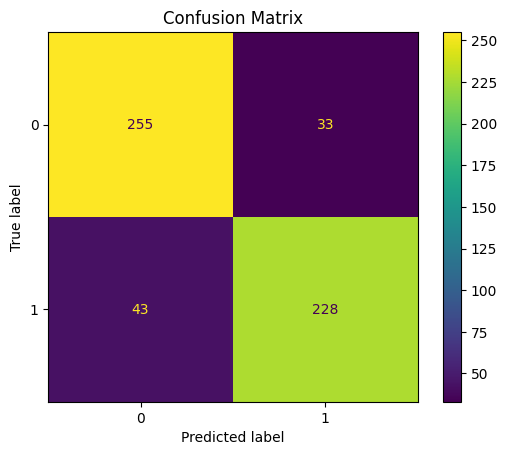

In [56]:
from sklearn.metrics import accuracy_score

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()